<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_PPG_simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook trains an simple PPG DNN by using labeled PPG data from Afib_Data_Clean notebook;
The loaded data is 30s segemented PPG signals with 125Hz sampling rate.

#2.Setup Environment



In [0]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

2.1.0


In [0]:
#run this cell to log device placement info
tf.debugging.set_log_device_placement(True)

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [0]:
tf.test.is_built_with_cuda()

True

#3.Data Pipeline

## 3.1 Input Data

###3.1.1 Concatenate
Run the following code if data and label have not been concatenated

In [0]:
#concatenate data
def concatenate_data(directory):
  raw_signals_list = []
  files_list = directory + "filtered_PPG*.pkl"
  for name in glob.glob(files_list):
    raw_signal = pickle.load(open(name,'rb'))
    raw_signals_list.append(raw_signal)
  raw_signals = [y for x in raw_signals_list for y in x]
  return raw_signals

In [0]:
#load PPG signal
raw_signals = concatenate_data('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/')

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/data', "wb") as fp:
  pickle.dump(raw_signals, fp)

In [0]:
#concatenate label
def concatenate_label(directory):
  raw_labels_list = []
  files_list = directory + "ECG_Afib_labels*.csv"
  for name in glob.glob(files_list):
    df = pd.read_csv(name,header=None)
    labels = df.to_numpy()
    raw_labels_list.append(labels.tolist())
    
  raw_labels = [y for x in raw_labels_list for y in x]
  return raw_labels

In [0]:
raw_labels = concatenate_label('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/')

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/labels', "wb") as fp:
  pickle.dump(raw_labels, fp)

###3.1.2 Load data and label

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/data', "rb") as fp:
  raw_signals = pickle.load(fp)

In [0]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib PPG data/015ECG_015PPG_flatline/labels', "rb") as fp:
  raw_labels = pickle.load(fp)

In [0]:
#create the right dim for signals
raw_signals = np.array(raw_signals)
print('signals dim before resize',raw_signals.shape)
raw_signals = np.expand_dims(raw_signals, axis=2)
print('signals dim:', raw_signals.shape)

signals dim before resize (450701, 3750)
signals dim: (450701, 3750, 1)


In [0]:
raw_labels = np.array(raw_labels)
print('labels dim',raw_labels.shape)

labels dim (450701, 1)


###3.1.2 Generate train,val and test

In [0]:
#ratio value is between 0 and 1
#make sure seed is set to a same number for repeatable results\
#or to compare models apple to apple
def slice_dataset(dataset,labels,train_ratio,seed = 10):  
  DATASET_SIZE =len(list(dataset)) #only works in eager mode (e.g. TF version >= 2.0.x)
  train_size = int(train_ratio * DATASET_SIZE)
  val_size = DATASET_SIZE - train_size
  
  np.random.seed(seed=seed)
  np.random.shuffle(dataset)
  train_dataset = dataset[:train_size,:,:]
  val_dataset = dataset[-val_size:,:,:]

  np.random.seed(seed=seed)
  np.random.shuffle(labels)
  train_labels = labels[:train_size,:]
  val_labels = labels[-val_size:,:]

  return train_dataset,val_dataset,train_labels, val_labels

Generate train, val and test data and labels

In [0]:
train_dataset, test_dataset, train_labels, test_labels  = slice_dataset(raw_signals,raw_labels,0.95)
print("train_dataset dim", train_dataset.shape)
print("train_labels dim", train_labels.shape)
print("test_dataset dim", test_dataset.shape)
print("test_labels dim", test_labels.shape)

train_dataset dim (428165, 3750, 1)
train_labels dim (428165, 1)
test_dataset dim (22536, 3750, 1)
test_labels dim (22536, 1)


In [0]:
train_dataset, val_dataset, train_labels, val_labels  = slice_dataset(train_dataset,train_labels,0.9)
print("train_dataset dim", train_dataset.shape)
print("train_labels dim", train_labels.shape)
print("val_dataset dim", val_dataset.shape)
print("val_labels dim", val_labels.shape)

train_dataset dim (385348, 3750, 1)
train_labels dim (385348, 1)
val_dataset dim (42817, 3750, 1)
val_labels dim (42817, 1)


Check the distribution of Afib and No-Afib

In [0]:
#check unique labels in train dataset
unique, count = np.unique(train_labels,return_counts=True)
print('There are', count[0], 'No Afib records in training dataset')
print('There are', count[1], 'Afib records in training dataset')

There are 305187 No Afib records in training dataset
There are 80161 Afib records in training dataset


In [0]:
#check unique labels in train dataset
unique, count = np.unique(val_labels,return_counts=True)
print('There are', count[0], 'No Afib records in validation dataset')
print('There are', count[1], 'Afib records in validation dataset')

There are 33911 No Afib records in validation dataset
There are 8906 Afib records in validation dataset


In [0]:
#check unique labels in test dataset
unique, count = np.unique(test_labels,return_counts=True)
print('There are', count[0], 'No Afib records in test dataset')
print('There are', count[1], 'Afib records in test dataset')

There are 17856 No Afib records in test dataset
There are 4680 Afib records in test dataset


## 3.2 Extract, Transform and Load data

###3.2.1 Parallelize Extraction

In [0]:
#use interleave if more than one file are used
train = tf.data.Dataset.from_tensor_slices((train_dataset,train_labels)) 

In [0]:
validation = tf.data.Dataset.from_tensor_slices((val_dataset,val_labels))

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


### 3.2.2 Parallelize Transformation


In [0]:
#don't need to run this cell, just as a placeholder
cores = multiprocessing.cpu_count()
print(cores)
#dataset = dataset.map(function, num_parallel_calls = cores)

12


### 3.2.3 Parallelize Loading

In [0]:
batch_size = 128
train_dataset = train.cache()
train_dataset = train_dataset.shuffle(len(list(train))).repeat().batch(batch_size,drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

Executing op AnonymousMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replic

#4.Train Model

##4.1 Build the model

In [0]:
#create a model
model = tf.keras.Sequential([
    #1st Conv1D
    tf.keras.layers.Conv1D(8, 1, strides=1, 
                          activation='relu', input_shape=(3750,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #2nd Conv1D
    tf.keras.layers.Conv1D(16, 3, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #3rd Conv1D
    tf.keras.layers.Conv1D(32, 3, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #4th Conv1D
    tf.keras.layers.Conv1D(64, 3, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    tf.keras.layers.Dropout(0.2),
    #5th Conv1D
    tf.keras.layers.Conv1D(16, 1, strides=1,
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #Full connection layer
    tf.keras.layers.Flatten(),
    #tf.keras.layers.LSTM(50, stateful=True, return_sequences=True),
    #tf.keras.layers.LSTM(10, stateful=True),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 3750, 8)           16        
_________________________________________________________________
batch_normalization_6 (Batch (None, 3750, 8)           32        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1875, 8)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1875, 8)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1873, 16)          400       
_________________________________________________________________
batch_normalization_7 (Batch (None, 1873, 16)          64        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 936, 16)          

##4.2 Define callbacks

###4.2.1 Learning rate scheduler

In [0]:
def decay(epoch):
  if epoch < 10:
    return 1e-3
  elif epoch >= 10 and epoch < 30:
    return 1e-4
  else:
    return 1e-5

In [0]:
#callback: schedule a learning rate incline iteration
lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)

###4.2.2 Tensorboard

In [0]:
#callback: tensorboard
log_dir=r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data\logs\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S") +"simpleCNN_015ECG_015PPG"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

###4.2.3 Confusion Matrix

In [0]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image,0)
    
    return image

In [0]:
class_names = ['NO Afib','Afib']

def plot_confusion_matrix(cm, class_names, normalize=False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.ylim(bottom=1.5,top = -0.5)
    
    if normalize:
      cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 1.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], 
               horizontalalignment="center", 
               verticalalignment='center', 
               color="white" if cm[i, j] > threshold else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [0]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(test_dataset)
    
    test_pred = np.where(test_pred_raw > 0.5, 1, 0)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names, normalize = True)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [0]:
#callback: confusion matrix
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)


###4.2.4 Checkpoint

In [0]:
#callback: checkpoint
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data\models\CNN-015ECG-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

##4.3 Train the model 

### 4.3.1 Start Training

In [0]:
#clear history if necessary
tf.keras.backend.clear_session()
#strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) ##to overwrite NCCL cross device communication as this is running in Windows
#with strategy.scope():

model = model

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy'])

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, lr_schedule]

#start training
model.fit(train_dataset,
          epochs=100,
          steps_per_epoch = len(list(train))/batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps = len(list(validation))/batch_size,
          callbacks=callbacks_list
          )

## 4.4 Save Model for future evaluation

In [0]:
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model.save('Deep_PPG_CNN_041120.h5')
print("Save model to disk")

Save model to disk


# 5.Model Evaluation

## 5.1 Load saved model

In [0]:
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data\models")
model = tf.keras.models.load_model('cp_model-96-0.0955.hdf5')

## 5.2 Confusion Matrix

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


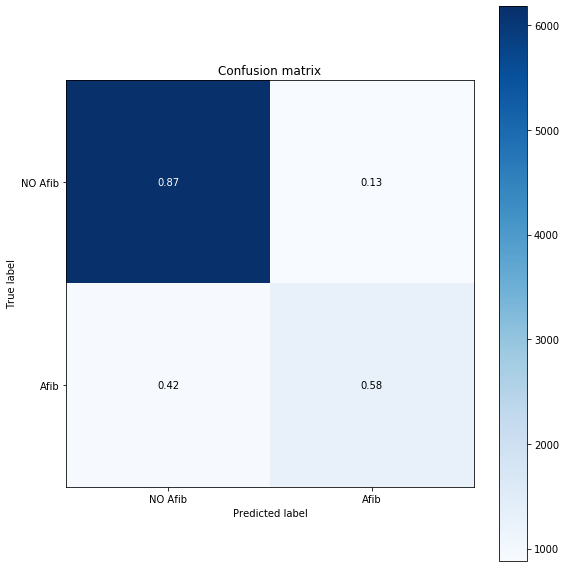

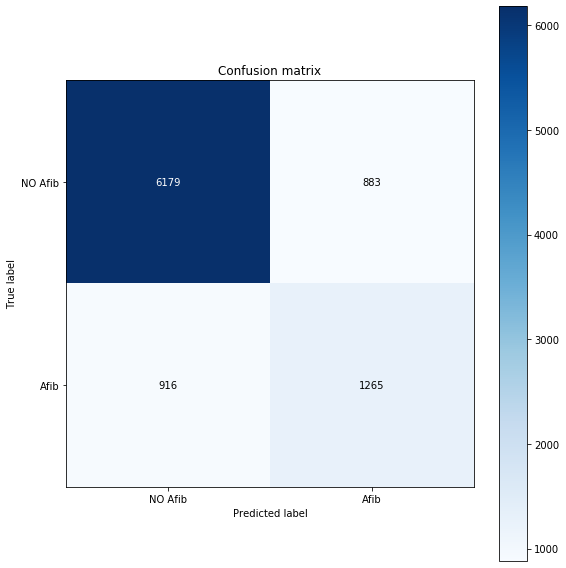

In [0]:
threshold = 0.5
test_pred_raw = model.predict(test_dataset)
test_pred = np.where(test_pred_raw > threshold, 1, 0)
# Calculate the confusion matrix using sklearn.metrics
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
figure_norm = plot_confusion_matrix(cm, class_names=class_names, normalize=True)
figure_norm.show()
figure = plot_confusion_matrix(cm, class_names=class_names, normalize=False)
figure.show()

## 5.3 F-1 Score

In [0]:
report = sklearn.metrics.classification_report(test_labels, test_pred)

In [0]:
print(report)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      3065
           1       0.40      0.41      0.41       925

    accuracy                           0.72      3990
   macro avg       0.61      0.61      0.61      3990
weighted avg       0.72      0.72      0.72      3990



## 5.4 AUC

In [0]:
score = sklearn.metrics.roc_auc_score(test_labels, test_pred)

In [0]:
print(score)

0.6136643005158503


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


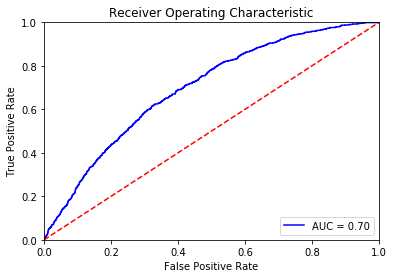

In [0]:
import sklearn.metrics as metrics
probs = model.predict_proba(test_signals)
preds = probs[:,]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()